# API

In [65]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# %load_ext line_profiler

In [3]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [69]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from pi_flux import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [68]:
# %%writefile pi_flux.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib

class Params:
    def __init__(self,
            Lx=16,
            Ly=16,
            t=1,
            Delta=1,
            m=0,
            bcx=-1,
            bcy=1,
            T=0,
            history=False,
            ):
        self.Lx=Lx
        self.Ly=Ly
        self.t = t
        self.Delta = Delta
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        if Lx<np.inf and Ly<np.inf:
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron(np.eye(Ly),hopx)
            hopymat = np.kron(hopy,np.eye(Lx))
            hop11mat= np.kron(hopy,hopx)
            hop1m1mat=np.kron(hopy.T,hopx)
            onsitemat = np.eye(Lx*Ly)
            H00=np.array([[m,-t,-1j*Delta,t],
                            [-t,-m,t,1j*Delta],
                            [1j*Delta,t,m,t],
                            [t,-1j*Delta,t,-m]])
            H10=np.array([[0,-t,1j*Delta,0],
                            [0,0,0,0],
                            [0,0,0,0],
                            [0,1j*Delta,t,0]])
            H01=np.array([[0,0,1j*Delta,t],
                            [0,0,t,-1j*Delta],
                            [0,0,0,0],
                            [0,0,0,0]])
            H11=np.array([[0,0,-1j*Delta,0],
                            [0,0,0,0],
                            [0,0,0,0],
                            [0,0,0,0]])
            H1m1=np.array([[0,0,0,0],
                            [0,0,0,0],
                            [0,0,0,0],
                            [0,-1j*Delta,0,0]])
            H00mat=np.kron(onsitemat,H00)
            H10mat=np.kron(hopxmat,H10)
            H01mat=np.kron(hopymat,H01)
            H11mat=np.kron(hop11mat,H11)
            H1m1mat=np.kron(hop1m1mat,H1m1)
            self.Hamiltonian=H00mat+H10mat+H10mat.T.conj()+H01mat+H01mat.T.conj()+H11mat+H11mat.T.conj()+H1m1mat+H1m1mat.T.conj()

    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix(self, E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f = ((occupancy_mat*self.vec)@self.vec.T.conj())

    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G = self.C_f
        Gamma_11 = 1j*(G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False, k=2):
        '''
        If proj ==True, then the index used for projection operator will be returned
        k, the size of measurement, is useful only when proj=True
        n=8 ususally, for 4 atoms in one unit cell and 2 Majorana operator 
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            assert subregion_x.max()<self.Lx and subregion_y.max()<self.Ly, 'Range exceeds'
            linear_index = ((X+Y*self.Lx).flatten('F'))
        else:
            assert subregion_x.max()<self.dxmax and subregion_y.max()<self.dymax, 'Range exceeds'
            linear_index = ((X+Y*self.dxmax).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, k)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def square_index(self, subregion):
        '''
        Convert indices in covariance matrix
        '''
        subregion=np.unique(np.array(subregion)//8)
        if self.Lx<np.inf and self.Ly<np.inf:
            return subregion%self.Lx,subregion//self.Lx
        else:
            return subregion%self.dxmax,subregion//self.dxmax

    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_f'):
            self.correlation_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True

        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 4)

        return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 2)
        subregion_B = self.linearize_index(subregion_B, 2)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB
        
    def log_neg(self, subregion_A, subregion_B, Gamma=None,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 4)
            subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)



    def projection(self, s,type='onsite',ignore=False):
            '''
            For type:'onsite'
                occupancy number: s= 0,1 
                (-1)^0 even parity, (-1)^1 odd parity
            For type:'link'
                (o,+)|(o,-)|(e,+)|(e,-)
            '''
            if type=='onsite':
                assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
                blkmat = np.array([[0, -(-1)**s, 0, 0],
                                [(-1)**s, 0, 0, 0],
                                [0, 0, 0, (-1)**s],
                                [0, 0, -(-1)**s, 0]])
                return blkmat
            if type=='link':
                assert (s in ['o+','o-','e+','e-']), "s={} for {} is not defined".format(s,type)
                if s=='o+':
                    antidiag=[1,-1,1,-1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)
                if s=='o-':
                    antidiag=[-1,1,-1,1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)
                if not ignore:
                    if s=='e+':
                        blkmat=np.array([[0,-1,0,0],
                                        [1,0,0,0],
                                        [0,0,0,-1],
                                        [0,0,1,0]])
                    if s=='e-':
                        blkmat=-np.array([[0,-1,0,0],
                                        [1,0,0,0],
                                        [0,0,0,-1],
                                        [0,0,1,0]])
                else:
                    if s=='e+':
                        antidiag=[-1,-1,1,1]
                        blkmat=np.diag(antidiag)
                        blkmat=np.fliplr(blkmat)
                    if s=='e-':
                        antidiag=[1,1,-1,-1]
                        blkmat=np.diag(antidiag)
                        blkmat=np.fliplr(blkmat)
                proj=np.zeros((8,8))
                proj[:4,:4]=blkmat
                proj[4:,4:]=blkmat.T
                return proj            
            raise ValueError("type '{}' is not defined".format(type))

    def measure(self, s, ix,type='onsite',ignore=False):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s,type=type,ignore=ignore)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(ix[0])
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [ix[0]]


    def measure_all_Born(self, proj_range,prob=None,linear=False,type='onsite',pool=4,ignore=False):
        if not linear:
            if type=='onsite':
                proj_range = self.linearize_index(proj_range, 8, proj=True)
            if type=='link':
                proj_range = self.linearize_index(proj_range, 8, proj=True,k=8)
        # self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.f_parity= []
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if type=='onsite':
            for i in proj_range:
                if prob is None:
                    P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
                else:
                    P_0=prob
                self.P_0_list.append(P_0)
                if np.random.rand() < P_0:
                    self.measure(0, [i, i+1])
                    self.f_parity.append(0)
                else:
                    self.measure(1, [i, i+1])
                    self.f_parity.append(1)
            return self

        if type=='link':
            pass
            # for i in proj_range:
            #     Gamma=self.C_m_history[-1][i:i+4,i:i+4]
            #     P={}
            #     gamma1234=-Gamma[0,1]*Gamma[2,3]+Gamma[0,2]*Gamma[1,3]-Gamma[0,3]*Gamma[1,2]
            #     if prob is None:
            #         P['o+']=(1+Gamma[1,2]-Gamma[0,3]+gamma1234)/4
            #         P['o-']=(1-Gamma[1,2]+Gamma[0,3]+gamma1234)/4
            #         if not ignore:
            #             P['e+']=(1+Gamma[0,1]+Gamma[2,3]-gamma1234)/4
            #             P['e-']=(1-Gamma[0,1]-Gamma[2,3]-gamma1234)/4
            #         else:
            #             #ignore symmetry
            #             P['e+']=(1+Gamma[1,2]+Gamma[0,3]-gamma1234)/4
            #             P['e-']=(1-Gamma[1,2]-Gamma[0,3]-gamma1234)/4
            #     else:
            #         P['o+'],P['o-'],P['e+'],P['e-']=tuple(prob)

            #     # print((P.values()))
            #     if pool==4:
            #         s=np.random.choice(['o+','o-','e+','e-'],p=[P['o+'],P['o-'],P['e+'],P['e-']])
            #     elif pool==2:
            #         s=np.random.choice(['o+','o-'],p=[P['o+']/(P['o+']+P['o-']),P['o-']/(P['o+']+P['o-'])])
            #     elif pool==-2:
            #         s=np.random.choice(['e+','e-'],p=[P['e+']/(P['e+']+P['e-']),P['e-']/(P['e+']+P['e-'])])
            #     self.measure(s,[i,i+1,i+2,i+3],type='link',ignore=ignore)
            return self

# test

In [5]:
params=Params(m=0)

In [6]:
params.covariance_matrix()

In [7]:
params.Lx//4

4

In [8]:
params.mutual_information_f([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//2,3*params.Lx//4),np.arange(params.Ly)])

0.02628849427926383

In [9]:
params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//2,3*params.Lx//4),np.arange(params.Ly)])

0.0262884942790933

In [10]:
params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//2,3*params.Lx//4),np.arange(params.Ly)])

0.03895508916636459

In [55]:
(params.Hamiltonian.T.conj()-params.Hamiltonian).nonzero()

(array([], dtype=int64), array([], dtype=int64))

# Bandstructure

In [95]:
m_list=np.linspace(-5,5)
Delta=1
eigval_pbc_new_list=[]
for m in m_list:
    params_new=Params(m=m,Delta=Delta,bcx=1,bcy=1,test='new',Lx=8,Ly=8)
    params_new.bandstructure()
    eigval_pbc_new_list.append(params_new.val)

In [96]:
Delta=1
eigval_apbc_new_list=[]
for m in m_list:
    params_new=Params(m=m,Delta=Delta,bcx=-1,bcy=1,test='new',Lx=8,Ly=8)
    params_new.bandstructure()
    eigval_apbc_new_list.append(params_new.val)

In [83]:
def h(m,t,Delta,kx,ky):
    mat=np.array([[m,-t*(1+np.exp(-1j*kx)),-1j*Delta*(1-np.exp(-1j*kx))*(1-np.exp(-1j*ky)),t*(1+np.exp(-1j*ky))],
                  [-t*(1+np.exp(1j*kx)),-m,t*(1+np.exp(-1j*ky)),1j*Delta*(1-np.exp(1j*kx))*(1-np.exp(-1j*ky))],
                  [1j*Delta*(1-np.exp(1j*kx))*(1-np.exp(1j*ky)),t*(1+np.exp(1j*ky)),m,t*(1+np.exp(1j*kx))],
                  [t*(1+np.exp(1j*ky)),-1j*Delta*(1-np.exp(-1j*kx))*(1-np.exp(1j*ky)),t*(1+np.exp(-1j*kx)),-m]])
    return nla.eigvalsh(mat)

In [102]:
bottom_list=[]
top_list=[]
# m_list=np.linspace(-5,5)
for m in m_list:
    en=np.abs(np.array([h(m,1,Delta,kx,ky) for kx in np.linspace(-np.pi,np.pi,10) for ky in np.linspace(-np.pi,np.pi,10)]))
    bottom_list.append(en.min())
    top_list.append(en.max())

In [173]:
Delta_list=np.linspace(-1,1)
m=0
eigval_pbc_Delta_m0_list=[]
for Delta in Delta_list:
    params_Delta=Params(m=m,Delta=Delta,bcx=1,bcy=1,Lx=8,Ly=8)
    params_Delta.bandstructure()
    eigval_pbc_Delta_m0_list.append(params_Delta.val)

In [174]:
Delta_list=np.linspace(-1,1)
m=0
eigval_apbc_Delta_m0_list=[]
for Delta in Delta_list:
    params_Delta=Params(m=m,Delta=Delta,bcx=-1,bcy=1,Lx=8,Ly=8)
    params_Delta.bandstructure()
    eigval_apbc_Delta_m0_list.append(params_Delta.val)

In [179]:
bottom_Delta_list=[]
top_Delta_list=[]
# Delta_list=np.linspace(-5,5)
for Delta in Delta_list:
    en=np.abs(np.array([h(m,1,Delta,kx,ky) for kx in np.linspace(-np.pi,np.pi,10) for ky in np.linspace(-np.pi,np.pi,10)]))
    bottom_Delta_list.append(en.min())
    top_Delta_list.append(en.max())

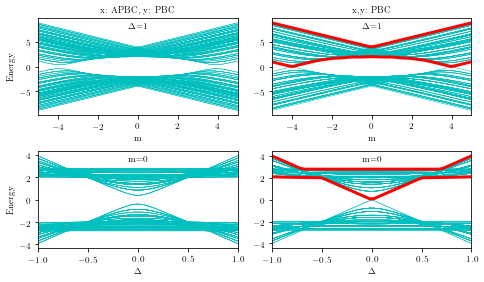

In [184]:
fig,ax=plt.subplots(2,2,tight_layout=True)
ax[0,0].plot(m_list,eigval_apbc_new_list,'c',lw=0.5)
ax[0,1].plot(m_list,eigval_pbc_new_list,'c',lw=0.5)

ax[0,1].plot(m_list,bottom_list,'r',lw=3)
ax[0,1].plot(m_list,top_list,'r',lw=3)
ax[0,0].set_title('x: APBC, y: PBC')
ax[0,1].set_title('x,y: PBC')
[ax.text(.5,.9,r'$\Delta$=1',transform=ax.transAxes,ha='center') for ax in ax[0]]


ax[1,0].plot(Delta_list,eigval_apbc_Delta_m0_list,'c',lw=0.5)
ax[1,1].plot(Delta_list,eigval_pbc_Delta_m0_list,'c',lw=0.5)
ax[1,1].plot(Delta_list,bottom_Delta_list,'r',lw=3)
ax[1,1].plot(Delta_list,top_Delta_list,'r',lw=3)

[ax.text(.5,.9,'m=0',transform=ax.transAxes,ha='center') for ax in ax[1]]

[ax.margins(x=0) for ax in ax.flatten()]
[ax.set_xlabel(r'm') for ax in ax[0]]
[ax.set_xlabel(r'$\Delta$') for ax in ax[1]]
[ax.set_ylabel(r'Energy') for ax in ax[:,0]]

fig.savefig('/mnt/d/kitp/Rp_SPT/10/bs.pdf',bbox_inches='tight')

# No measurement 

## m dependence

In [57]:
m_list=(lambda x:(x-4)**3+4 )(np.linspace(3,5,24))
# m_list=np.linspace(3,5,20)
LN_m_no_list=[]
MI_m_no_list=[]
Lx=64
Ly=4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly)
    MI=(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    LN=(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    return MI,LN

inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_m_no_list.append(results[0])
    LN_m_no_list.append(results[1])


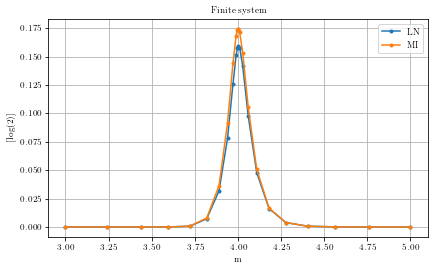

In [58]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_m_no_list/np.log(2),'.-',label='LN')
ax.plot(m_list,MI_m_no_list/np.log(2),'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.grid('on')
ax.set_ylabel('[log(2)]')
ax.set_title('Finite system')
fig.savefig('/mnt/d/kitp/Rp_SPT/10/LN_CI_no_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Delta dependence

In [79]:
Delta_list=(lambda x:(x)**3)(np.linspace(-1,1,24))
# Delta_list=np.linspace(-1,1,20)
LN_Delta_no_list=[]
MI_Delta_no_list=[]
Lx=32
Ly=4
def run(p):
    Delta,Lx,Ly=p
    params=Params(m=0,Lx=Lx,Ly=Ly,Delta=Delta)
    MI=(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    LN=(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    return MI,LN

inputs=[(Delta,Lx,Ly) for Delta in Delta_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Delta_no_list.append(results[0])
    LN_Delta_no_list.append(results[1])


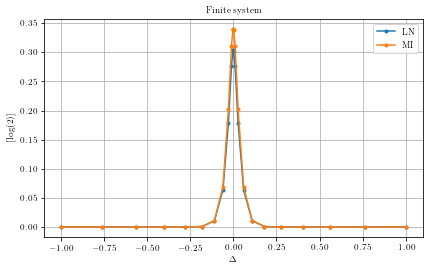

In [80]:
fig,ax=plt.subplots()
ax.plot(Delta_list,LN_Delta_no_list/np.log(2),'.-',label='LN')
ax.plot(Delta_list,MI_Delta_no_list/np.log(2),'.-',label='MI')
ax.legend()
ax.set_xlabel(r'$\Delta$')
ax.grid('on')
ax.set_ylabel('[log(2)]')
ax.set_title('Finite system')
fig.savefig('/mnt/d/kitp/Rp_SPT/10/LN_CI_no_Delta_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

# Born measurement

## Onsite, m dep

In [85]:
m_list=(lambda x:(x-4)**3+4 )(np.linspace(3,5,24))
es=20
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_list[m_i,index],LN_Born_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


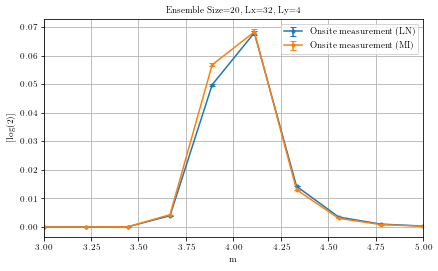

In [82]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'[log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_onsite_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Onsite, $\Delta$ dep

In [83]:
Delta_list=(lambda x:(x)**3)(np.linspace(-1,1,24))
es=20
LN_Born_list=np.zeros((len(Delta_list),es))
MI_Born_list=np.zeros((len(Delta_list),es))
Lx,Ly=32,4
def run(p):
    Delta,Lx,Ly=p
    params=Params(m=0,Delta=Delta,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for Delta_i,Delta in enumerate(Delta_list):
    st=time.time()
    # # Serial
    # params0=Params(Delta=Delta,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_list[Delta_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_list[Delta_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(Delta,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_list[Delta_i,index],LN_Born_list[Delta_i,index]=results

    print('{:d}:{:.1f}'.format(Delta_i,time.time()-st))


0:25.5
1:24.8
2:24.9
3:24.5
4:24.6
5:24.4
6:24.8
7:23.9
8:24.4
9:25.2


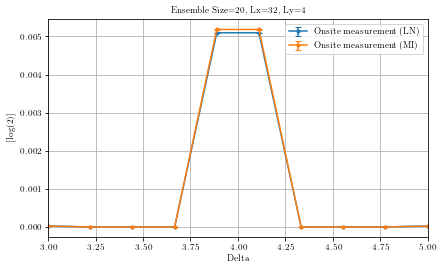

In [84]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'Delta')
ax.set_ylabel(r'[log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_Delta_onsite_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link $\Delta$ dep

## Link $\Delta$ dep

## Link $\Delta$ dep